# Hurricane Damage Detector

This project works on an open dataset consisting of satellite imagery data to detect damaged buildings due to a hurricane. These satellite images are taken from the aftermath of Hurricane Harvey in 2017. The aim is to build a classifier which can identify if a specific region (based on the input satellite image) is likely to have suffered from flooding and other typical structural damages due to Hurricane Harvey.

The dataset has been taken from IEEE Dataport and modified to build a balanced dataset of satellite images which either signify the present of damaged buildings or buildings with no damage. The focus is to build a binary classifier to classify images as "damage" or "no_damage" by using a combination of Convolutional Neural Network (CNN) and transfer learning.

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
!unzip -q hurricane_detector.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=93d4848d-e3b8-460e-bff4-dbba40e34572
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 268MB/s]
replace train_hurricane/no_damage/-95.638504_29.838933.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Load Dependencies

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, Sequential
tf.random.set_seed(18)

# display progress bar to track progress of machine learning
from tqdm import tqdm

## Define functions to create dataset generators

In [3]:
# Split the train dataset in 80:20 ratio (train:validation)
# Resize images to 128x128 for quicker modeling
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ["no_damage", "damage"]

# Data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=["no_damage", "damage"],
        seed=18,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=["no_damage", "damage"],
        seed=18,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# Get prediction of test data based on trained models
# Return the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=["no_damage", "damage"],
        seed=18,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc="Predicting on Test Data"):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [4]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


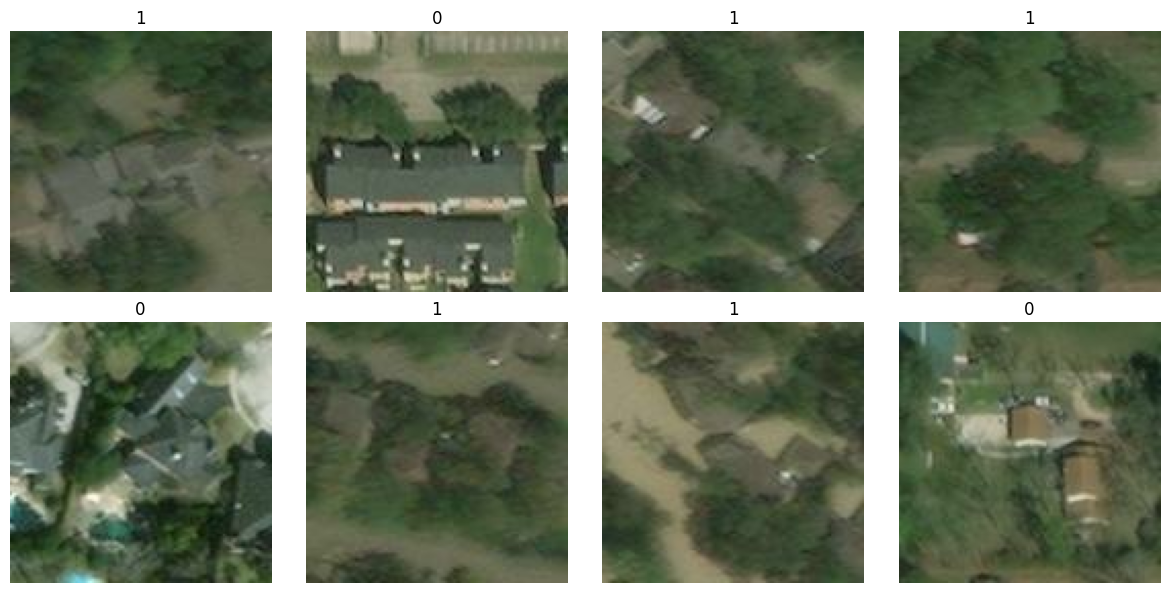

In [6]:
# Display examples of satellite images and labels in the datasets
plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## <font color="blue"> Model 1: Baseline model </font>

Build a basic CNN model with 3 layers, which serves as a baseline model. The model consists of three convolution blocks with a max pool layer in each of them. There is a fully connected layer with 128 units on top of it that is activated by a "relu" activation function. This model has not been tuned for high accuracy, it is a baseline model.

In [7]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

## Compile the model

This baseline model uses the "Adam" optimizer and the "BinaryCrossentropy" loss function. The "metrics" argument is used to view training and validation accuracy for each training epoch.

In [8]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=["accuracy"])

## Show the model summary

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

## Train the model

In [10]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
34/34 [==============================] - 6s 32ms/step - loss: 0.6927 - accuracy: 0.5557 - val_loss: 0.6337 - val_accuracy: 0.6790
Epoch 2/10
34/34 [==============================] - 1s 19ms/step - loss: 0.5658 - accuracy: 0.7259 - val_loss: 0.4832 - val_accuracy: 0.7638
Epoch 3/10
34/34 [==============================] - 1s 17ms/step - loss: 0.4466 - accuracy: 0.8013 - val_loss: 0.3782 - val_accuracy: 0.8745
Epoch 4/10
34/34 [==============================] - 1s 16ms/step - loss: 0.4144 - accuracy: 0.8326 - val_loss: 0.3784 - val_accuracy: 0.8413
Epoch 5/10
34/34 [==============================] - 1s 17ms/step - loss: 0.2958 - accuracy: 0.8841 - val_loss: 0.4671 - val_accuracy: 0.7528
Epoch 6/10
34/34 [==============================] - 1s 17ms/step - loss: 0.2758 - accuracy: 0.8905 - val_loss: 0.3007 - val_accuracy: 0.9114
Epoch 7/10
34/34 [==============================] - 1s 18ms/step - loss: 0.2126 - accuracy: 0.9154 - val_loss: 0.3050 - val_accuracy: 0.8819
Epoch 8/10
34

## Visualize training results

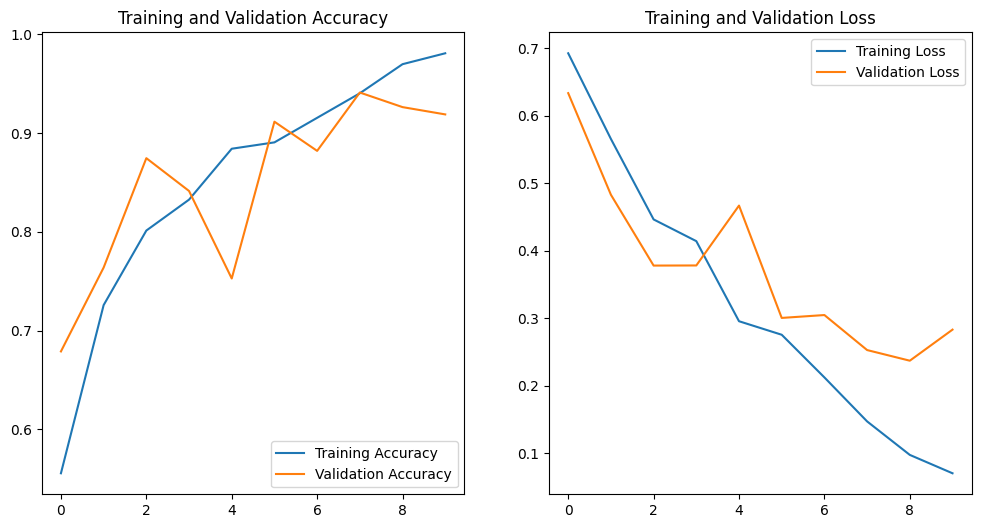

In [11]:
# Create plots of loss and accuracy on the training and validation datasets

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## <font color="blue"> Model 2: Baseline model with augmentation and dropout </font>

This builds on the baseline model by adding augmentation and dropout layers to reduce overfitting.

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                    .shuffle(2000)
                    .prefetch(buffer_size=tf.data.AUTOTUNE))
```
_Note: The data augmentation above was run but it did not improve the model accuracy, so data augmentation was not included._

In [12]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

## Compile the model

In [13]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=["accuracy"])

## Show the model summary

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)       

## Train the model

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
34/34 [==============================] - 3s 30ms/step - loss: 0.6967 - accuracy: 0.5262 - val_loss: 0.6397 - val_accuracy: 0.6052
Epoch 2/10
34/34 [==============================] - 1s 32ms/step - loss: 0.5984 - accuracy: 0.6872 - val_loss: 0.4941 - val_accuracy: 0.8450
Epoch 3/10
34/34 [==============================] - 1s 27ms/step - loss: 0.4769 - accuracy: 0.7985 - val_loss: 0.4145 - val_accuracy: 0.8672
Epoch 4/10
34/34 [==============================] - 1s 19ms/step - loss: 0.3800 - accuracy: 0.8445 - val_loss: 0.5588 - val_accuracy: 0.6716
Epoch 5/10
34/34 [==============================] - 1s 20ms/step - loss: 0.3523 - accuracy: 0.8666 - val_loss: 0.3508 - val_accuracy: 0.8893
Epoch 6/10
34/34 [==============================] - 1s 23ms/step - loss: 0.2620 - accuracy: 0.8942 - val_loss: 0.3373 - val_accuracy: 0.8635
Epoch 7/10
34/34 [==============================] - 1s 18ms/step - loss: 0.2554 - accuracy: 0.9144 - val_loss: 0.3435 - val_accuracy: 0.8967
Epoch 8/10
34

## Visualize training results

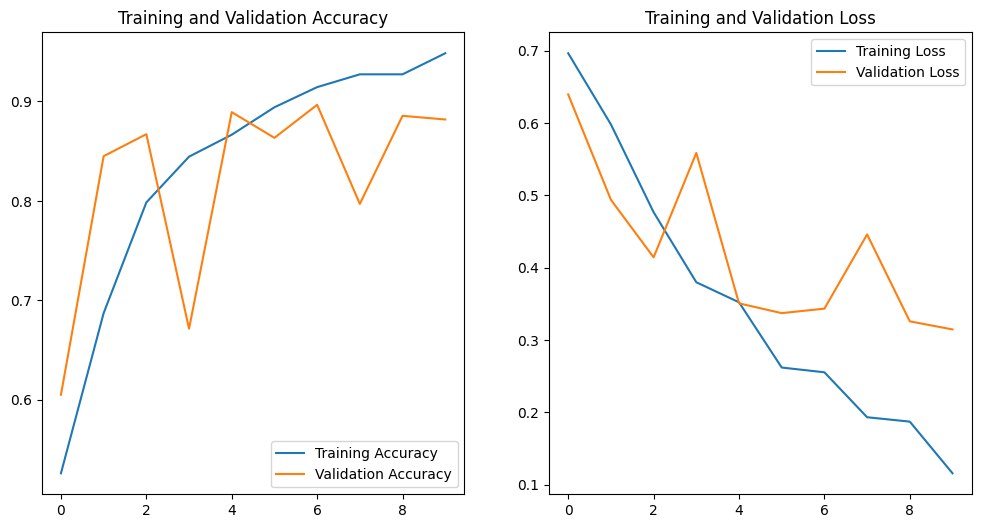

In [16]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## <font color="blue"> Model 3: Transfer learning (VGG19) without fine-tuning


The **VGG19** model is a pre-trained model using the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like "dogs" and "fruits".

In [17]:
# Define functions to create dataset generators as before
# Resize the images to 224x224 to follow the image size of the pre-trained VGG19 model

IMG_DIMS = (224, 224)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ["no_damage", "damage"]

def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=["no_damage", "damage"],
        seed=18,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=["no_damage", "damage"],
        seed=18,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=["no_damage", "damage"],
        seed=18,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc="Predicting on Test Data"):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [18]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


## Create the base model from the pre-trained VGG19 model

Use the **VGG19** model as the base model. Its very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful for classifying images of hurricane damage, as the images the VGG19 model was trained on were other non-related images on ImageNet. So, the top layer is excluded from the model. This follows the common practice to depend on the layers before the very last layer. This final layer is called the "bottleneck layer". The layers before the bottleneck layer retain more generality as compared to the final/top layer.

First step is to instantiate a VGG19 model pre-loaded with weights trained on ImageNet. Specify the _include_top=False_ argument, so that it loads a network that does not include the classification layer at the top.

In [19]:
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(224,224,3),
                                              include_top=False,
                                              weights="imagenet",
                                                    )

## Freeze the convolutional base

Freeze the convolutional base created from the previous step. In addition, add a classifier on top of it and train the top-level classifier, as the top layer from the pre-trained VGG19 model was excluded.

It is important to freeze the convolutional base before compiling and training the model by setting _layer.trainable=False_. This is to prevent the weights of the pre-trained VGG19 model from being updated during training. VGG19 has many layers, so setting the entire model's "trainable" flag to False will freeze all of the layers.

In [20]:
base_model.trainable = False

## Build the model architecture

Build a model by chaining together the VGG19 preprocessing, the VGG19 base model, and the final classification layer. The option _training=False_ is used, just in case the pre-trained model contains a BatchNormalization layer.

In [21]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.vgg19.preprocess_input(inputs)
x = base_model(x, training=False)  # important: training=False
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

Use the same optimizer and loss function as before, but chang the learning rate of the optimizer to something smaller.  

In [22]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                             

## Train the model

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
34/34 [==============================] - 20s 401ms/step - loss: 3.2068 - accuracy: 0.7654 - val_loss: 0.2746 - val_accuracy: 0.9004
Epoch 2/10
34/34 [==============================] - 7s 208ms/step - loss: 0.0898 - accuracy: 0.9641 - val_loss: 0.1989 - val_accuracy: 0.9336
Epoch 3/10
34/34 [==============================] - 7s 199ms/step - loss: 0.0201 - accuracy: 0.9963 - val_loss: 0.1822 - val_accuracy: 0.9446
Epoch 4/10
34/34 [==============================] - 7s 207ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1820 - val_accuracy: 0.9557
Epoch 5/10
34/34 [==============================] - 7s 200ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1841 - val_accuracy: 0.9557
Epoch 6/10
34/34 [==============================] - 7s 214ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1873 - val_accuracy: 0.9557
Epoch 7/10
34/34 [==============================] - 8s 233ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1911 - val_accuracy: 0.9594
Epoch

## Visualize training results

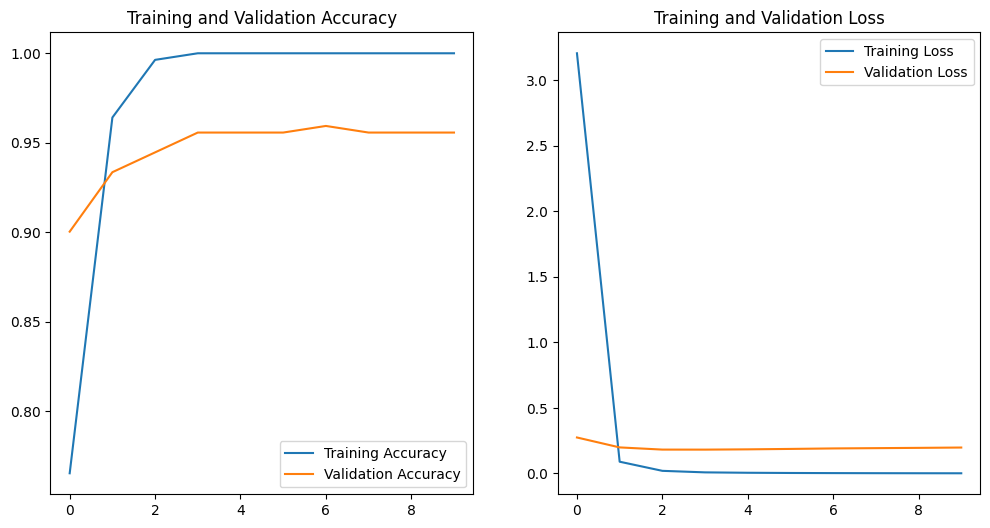

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## <font color="blue"> Model 4: Transfer learning (VGG19) with some pre-trained layers being opened for fine-tuning

## Create the base model from the pre-trained VGG19 model


In [26]:
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(224,224,3),
                                              include_top=False,
                                              weights="imagenet",
                                                    )

## Unfreeze part of the convolutional base

Unfreeze part of the convolutional base created from the previous step. In addition, add a classifier on top of it and train the top-level classifier, as the top layer from the pre-trained VGG19 model was excluded.

The layers closer to the top classification layer are more specific to the images on ImageNet that are being used to train the VGG19 model. The weights for these layers are being opened for fine-tuning. The lower levels of layers are more generic and should be able to apply all images and not just the images on ImageNet. The weights of these lower levels of pre-trained VGG19 model are frozen and cannot be updated during training. Only the weights of the top few layers are opened for fine-tuning.

In [27]:
base_model.trainable = True

# The number of layers that are in the base VGG19 model
print("Number of layers in the base VGG19 model: ", len(base_model.layers))

Number of layers in the base VGG19 model:  22


In [28]:
# Fine-tune from this layer onwards
# Use the cutoff at the following layers: 18, 17, 16, 15,
fine_tune_at = 16   # cutoff at 16 produces the highest model accuracy

# Freeze all the layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

## Build the model architecture

Build a model by chaining together the VGG19 preprocessing, the VGG19 base model, and the final classification layer. The option _training=False_ is used, just in case the pre-trained model contains a BatchNormalization layer.

In [29]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.vgg19.preprocess_input(inputs)
x = base_model(x, training=False)  # important: training=False
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

Use the same optimizer and loss function as before, but change the learning rate of the optimizer to something smaller. This is to prevent the weights of the pre-trained model that have been unfrozen from being modified to quickly.

In [30]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422

## Train the model

In [32]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
early_stopping_cb

In [33]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_cb]
)

Epoch 1/20
34/34 [==============================] - 13s 274ms/step - loss: 0.5766 - accuracy: 0.8096 - val_loss: 0.2081 - val_accuracy: 0.9225
Epoch 2/20
34/34 [==============================] - 8s 238ms/step - loss: 0.0665 - accuracy: 0.9742 - val_loss: 0.3304 - val_accuracy: 0.9336
Epoch 3/20
34/34 [==============================] - 8s 244ms/step - loss: 0.0641 - accuracy: 0.9742 - val_loss: 0.1921 - val_accuracy: 0.9410
Epoch 4/20
34/34 [==============================] - 9s 251ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.1795 - val_accuracy: 0.9446
Epoch 5/20
34/34 [==============================] - 8s 244ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2356 - val_accuracy: 0.9446
Epoch 6/20
34/34 [==============================] - 8s 243ms/step - loss: 4.4505e-04 - accuracy: 1.0000 - val_loss: 0.2423 - val_accuracy: 0.9483
Epoch 7/20
34/34 [==============================] - 9s 248ms/step - loss: 1.8940e-04 - accuracy: 1.0000 - val_loss: 0.2500 - val_accuracy: 0.94

## Visualize training results

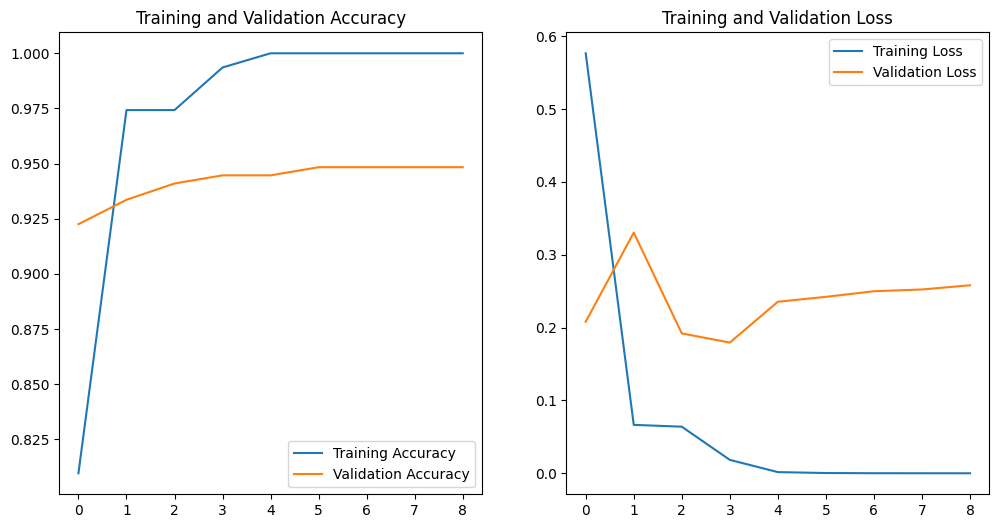

In [34]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs_range = range(early_stopping_cb.stopped_epoch + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Examine model performance using test dataset

In [35]:
y_true, y_pred = eval_model_on_test(model)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 170ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:57,  1.87s/it]

4/4 [==============================] - 0s 150ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:54,  1.22s/it]

4/4 [==============================] - 0s 150ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:03<01:33,  1.01s/it]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:04<01:46,  1.16s/it]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:06<01:53,  1.25s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:07<01:42,  1.13s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:08<01:52,  1.26s/it]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:09<01:37,  1.11s/it]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:10<01:43,  1.19s/it]

4/4 [==============================] - 0s 152ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:11<01:31,  1.06s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:12<01:22,  1.03it/s]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:13<01:19,  1.05it/s]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:14<01:16,  1.09it/s]

4/4 [==============================] - 0s 154ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:14<01:11,  1.15it/s]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:16<01:23,  1.03s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:17<01:17,  1.03it/s]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:18<01:26,  1.10s/it]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:19<01:21,  1.04s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:20<01:30,  1.17s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:22<01:33,  1.23s/it]

4/4 [==============================] - 1s 152ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:23<01:35,  1.28s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:24<01:23,  1.13s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:25<01:28,  1.21s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:27<01:31,  1.27s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:28<01:32,  1.30s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:29<01:32,  1.33s/it]

4/4 [==============================] - 1s 160ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:30<01:19,  1.16s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:31<01:13,  1.08s/it]

4/4 [==============================] - 1s 161ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:33<01:20,  1.20s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:34<01:22,  1.25s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:35<01:23,  1.29s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:37<01:25,  1.33s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:38<01:13,  1.16s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:38<01:04,  1.04s/it]

4/4 [==============================] - 1s 161ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:40<01:09,  1.14s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:41<01:13,  1.22s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:42<01:04,  1.10s/it]

4/4 [==============================] - 1s 160ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:43<01:00,  1.04s/it]

4/4 [==============================] - 1s 163ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:44<00:57,  1.01s/it]

4/4 [==============================] - 1s 160ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:45<00:55,  1.00it/s]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:46<00:52,  1.05it/s]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:47<00:58,  1.08s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:48<00:51,  1.02it/s]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:49<00:57,  1.10s/it]

4/4 [==============================] - 1s 162ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:50<01:00,  1.19s/it]

4/4 [==============================] - 1s 160ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:51<00:54,  1.08s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:53<00:57,  1.17s/it]

4/4 [==============================] - 1s 161ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:53<00:50,  1.06s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:55<00:55,  1.17s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:56<00:50,  1.10s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:57<00:46,  1.02s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:57<00:42,  1.04it/s]

4/4 [==============================] - 1s 160ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:59<00:46,  1.08s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [01:00<00:49,  1.18s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [01:01<00:43,  1.06s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [01:02<00:46,  1.17s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [01:04<00:47,  1.23s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  60%|██████    | 58/96 [01:05<00:48,  1.27s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [01:07<00:48,  1.31s/it]

4/4 [==============================] - 1s 161ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [01:07<00:41,  1.16s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [01:08<00:38,  1.10s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [01:09<00:34,  1.02s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [01:10<00:31,  1.06it/s]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [01:11<00:28,  1.10it/s]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [01:12<00:32,  1.06s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [01:13<00:29,  1.03it/s]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [01:14<00:26,  1.10it/s]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  71%|███████   | 68/96 [01:14<00:24,  1.15it/s]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [01:15<00:22,  1.19it/s]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [01:17<00:26,  1.00s/it]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [01:18<00:27,  1.12s/it]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [01:19<00:28,  1.21s/it]

4/4 [==============================] - 1s 161ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [01:20<00:26,  1.15s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [01:22<00:27,  1.26s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [01:23<00:23,  1.11s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [01:24<00:23,  1.19s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  80%|████████  | 77/96 [01:25<00:20,  1.05s/it]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [01:26<00:17,  1.03it/s]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [01:27<00:18,  1.10s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [01:28<00:18,  1.18s/it]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [01:30<00:18,  1.26s/it]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [01:31<00:15,  1.11s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [01:31<00:13,  1.01s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [01:32<00:11,  1.01it/s]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:33<00:10,  1.06it/s]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:35<00:10,  1.07s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [01:36<00:10,  1.16s/it]

4/4 [==============================] - 0s 154ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:37<00:09,  1.23s/it]

4/4 [==============================] - 0s 155ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:39<00:09,  1.29s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:40<00:07,  1.31s/it]

4/4 [==============================] - 0s 156ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:41<00:05,  1.14s/it]

4/4 [==============================] - 0s 155ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:42<00:04,  1.02s/it]

4/4 [==============================] - 0s 155ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:43<00:03,  1.13s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:44<00:02,  1.02s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:44<00:00,  1.06it/s]

3/3 [==============================] - 2s 665ms/step


Predicting on Test Data: 100%|██████████| 96/96 [02:21<00:00,  1.48s/it]


In [36]:
# Predict on unseen X_test
y_pred01 = (y_pred > 0.5).astype("int32")
# Print classification report
print("Classification report: \n")
print(classification_report(y_true, y_pred01))
# Print confusion matrix
print("Confusion matrix: \n")
pd.DataFrame(confusion_matrix(y_true, y_pred01))

Classification report: 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      6333
           1       0.93      0.95      0.94      5895

    accuracy                           0.94     12228
   macro avg       0.94      0.94      0.94     12228
weighted avg       0.94      0.94      0.94     12228

Confusion matrix: 



,0,1
0,5941,392
1,306,5589


## <font color="blue"> Model 5: Transfer learning (ResNet50) with some pre-trained layers being opened for fine-tuning

The **ResNet50** model is a pre-trained model using the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like "dogs" and "fruits".

## Create the base model from the pre-trained ResNet50


In [37]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                              include_top=False,
                                              weights="imagenet",
                                                    )

## Unfreeze part of the convolutional base

Unfreeze part of the convolutional base created from the previous step. In addition, add a classifier on top of it and train the top-level classifier, as the top layer from the pre-trained ResNet50 model was excluded.

The layers closer to the top classification layer are more specific to the images on ImageNet that are being used to train the ResNet50 model. The weights for these layers are being opened for fine-tuning. The lower levels of layers are more generic and should be able to apply all images and not just the images on ImageNet. The weights of these lower levels of pre-trained ResNet50 model are frozen and cannot be updated during training. Only the weights of the top few layers are opened for fine-tuning.

In [38]:
base_model.trainable = True

# The number of layers that are in the base ResNet50 model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [39]:
# Fine-tune from this layer onwards
# Use the cutoff at the following layers: 175, 165, 155, 145, 135, 125
fine_tune_at = 145   # cutoff at 145 produces the highest model accuracy

# Freeze all the layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

## Build the model architecture

Build a model by chaining together the ResNet50 preprocessing, the ResNet50 base model, and the final classification layer. The option _training=False_ is used, just in case the pre-trained model contains a BatchNormalization layer.

In [40]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)  # important: training=False
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

Use the same optimizer and loss function as before, but change the learning rate of the optimizer to something smaller. This is to prevent the weights of the pre-trained model that have been unfrozen from being modified to quickly.

In [41]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [ ]:
model.summary()

## Train the model

In [42]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
early_stopping_cb

In [43]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_cb]
)

Epoch 1/20
34/34 [==============================] - 21s 278ms/step - loss: 0.7964 - accuracy: 0.8050 - val_loss: 0.1547 - val_accuracy: 0.9336
Epoch 2/20
34/34 [==============================] - 6s 166ms/step - loss: 0.0636 - accuracy: 0.9788 - val_loss: 0.1938 - val_accuracy: 0.9336
Epoch 3/20
34/34 [==============================] - 6s 173ms/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 0.1854 - val_accuracy: 0.9520
Epoch 4/20
34/34 [==============================] - 6s 166ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1963 - val_accuracy: 0.9483
Epoch 5/20
34/34 [==============================] - 6s 169ms/step - loss: 3.3279e-04 - accuracy: 1.0000 - val_loss: 0.2051 - val_accuracy: 0.9410
Epoch 6/20
34/34 [==============================] - 6s 175ms/step - loss: 2.1137e-04 - accuracy: 1.0000 - val_loss: 0.2200 - val_accuracy: 0.9483


## Visualize training results

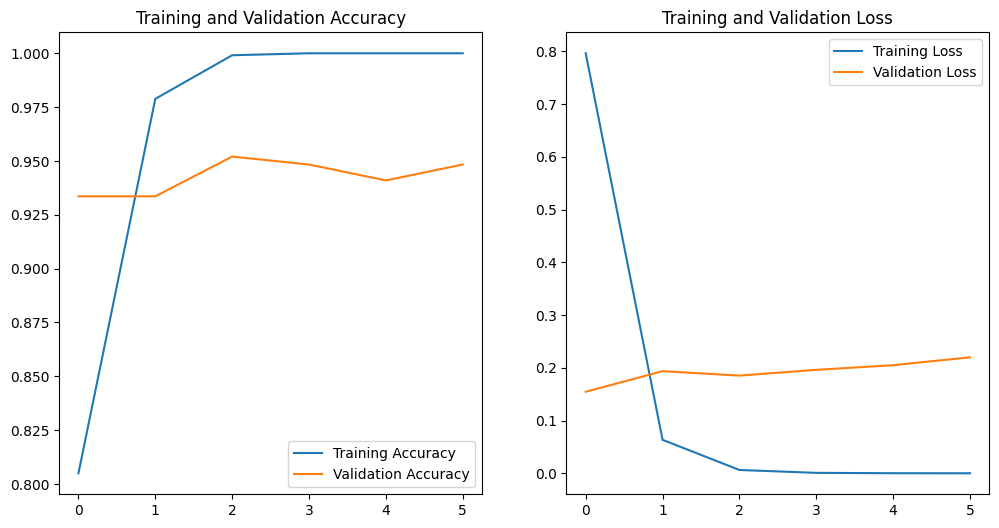

In [44]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs_range = range(early_stopping_cb.stopped_epoch + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Examine model performance using test dataset

In [45]:
y_true, y_pred = eval_model_on_test(model)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 2s 107ms/step


Predicting on Test Data:   1%|          | 1/96 [00:03<05:22,  3.40s/it]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:04<02:52,  1.83s/it]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:04<01:54,  1.23s/it]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:05<01:35,  1.04s/it]

4/4 [==============================] - 0s 97ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:06<01:24,  1.07it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:06<01:17,  1.16it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:07<01:13,  1.20it/s]

4/4 [==============================] - 0s 96ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:08<01:04,  1.36it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:08<01:03,  1.36it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:09<01:04,  1.34it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:10<01:03,  1.34it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:11<01:02,  1.34it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:11<00:55,  1.49it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:12<00:52,  1.57it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:12<00:54,  1.48it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:13<00:59,  1.35it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:14<01:01,  1.28it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:15<00:55,  1.40it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:15<00:50,  1.52it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:16<00:47,  1.61it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:16<00:43,  1.72it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:17<00:46,  1.59it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:18<00:49,  1.49it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:18<00:44,  1.62it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:19<00:41,  1.70it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:19<00:40,  1.74it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:20<00:43,  1.59it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:21<00:45,  1.50it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:22<00:45,  1.46it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:22<00:46,  1.42it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:23<00:41,  1.56it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:23<00:38,  1.67it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:24<00:40,  1.55it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:25<00:40,  1.54it/s]

4/4 [==============================] - 0s 99ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:26<00:42,  1.43it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:26<00:44,  1.34it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:27<00:43,  1.35it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:28<00:42,  1.35it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:28<00:37,  1.51it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:29<00:34,  1.64it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:30<00:35,  1.53it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:30<00:37,  1.45it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:31<00:34,  1.54it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:32<00:31,  1.64it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:32<00:29,  1.73it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:33<00:27,  1.79it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:33<00:26,  1.83it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:34<00:25,  1.87it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:34<00:27,  1.68it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:35<00:29,  1.55it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:36<00:31,  1.45it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:36<00:28,  1.54it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:37<00:28,  1.52it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:38<00:27,  1.54it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:38<00:26,  1.53it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:39<00:27,  1.43it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:40<00:25,  1.56it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:40<00:22,  1.66it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:41<00:24,  1.50it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:42<00:22,  1.59it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:42<00:23,  1.51it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:43<00:20,  1.62it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:44<00:21,  1.52it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:44<00:20,  1.60it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:45<00:18,  1.69it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:45<00:19,  1.56it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:46<00:19,  1.46it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:47<00:19,  1.41it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:47<00:17,  1.51it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:48<00:17,  1.46it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:49<00:15,  1.57it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:49<00:15,  1.58it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:50<00:14,  1.56it/s]

4/4 [==============================] - 0s 96ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:51<00:15,  1.40it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:51<00:13,  1.51it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:52<00:12,  1.63it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:52<00:10,  1.73it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:53<00:10,  1.80it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:54<00:10,  1.63it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:54<00:09,  1.70it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:55<00:09,  1.58it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:56<00:09,  1.49it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:57<00:09,  1.42it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:57<00:07,  1.54it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:58<00:07,  1.47it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:59<00:07,  1.42it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:59<00:05,  1.57it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:00<00:04,  1.69it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:00<00:04,  1.59it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:01<00:04,  1.50it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:02<00:03,  1.42it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:02<00:02,  1.47it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:03<00:01,  1.55it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:04<00:01,  1.49it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:04<00:00,  1.63it/s]

3/3 [==============================] - 2s 352ms/step


Predicting on Test Data: 100%|██████████| 96/96 [01:21<00:00,  1.17it/s]


In [46]:
# Predict on unseen X_test
y_pred01 = (y_pred > 0.5).astype("int32")
# Print classification report
print("Classification report: \n")
print(classification_report(y_true, y_pred01))
# Print confusion matrix
print("Confusion matrix: \n")
pd.DataFrame(confusion_matrix(y_true, y_pred01))

Classification report: 

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      6333
           1       0.93      0.92      0.92      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228

Confusion matrix: 



,0,1
0,5908,425
1,500,5395
